In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm

from datetime import datetime, timedelta
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [2]:
dataset_path = 'AAPL_new_sep_time.csv'
chunksize = 100000
tfr = pd.read_csv(dataset_path, chunksize=chunksize, iterator=True)
read_df = pd.concat(tfr, ignore_index=True)

read_df.head()

,Unnamed: 0,#RIC,Domain,Date-Time,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date-Time_ntz,Date,Time,Direction
0,0,AAPL.OQ,Market Price,2023-09-01 09:30:00.001188961-04:00,Trade,189.57,300.0,NaN,NaN,NaN,NaN,NaN,2023-09-01 09:30:00.001188961,2023-09-01,09:30:00.001188,NaN
1,1,AAPL.OQ,Market Price,2023-09-01 09:30:00.006152553-04:00,Trade,189.57,1221.0,NaN,NaN,NaN,NaN,NaN,2023-09-01 09:30:00.006152553,2023-09-01,09:30:00.006152,NaN
2,2,AAPL.OQ,Market Price,2023-09-01 09:30:00.011164045-04:00,Trade,189.57,100.0,NaN,NaN,NaN,NaN,NaN,2023-09-01 09:30:00.011164045,2023-09-01,09:30:00.011164,NaN
3,3,AAPL.OQ,Market Price,2023-09-01 09:30:00.011164045-04:00,Trade,189.57,159.0,NaN,NaN,NaN,NaN,NaN,2023-09-01 09:30:00.011164045,2023-09-01,09:30:00.011164,NaN
4,4,AAPL.OQ,Market Price,2023-09-01 09:30:00.011164045-04:00,Trade,189.57,50.0,NaN,NaN,NaN,NaN,NaN,2023-09-01 09:30:00.011164045,2023-09-01,09:30:00.011164,NaN


In [3]:
def clean_data(or_df):
    """
    Data cleansing
    Parameters
    ----------
    or_df : pd.DataFrame
    DataFrame containing the original data before cleansing
    Returns
    -------
    cleaned : pd.DataFrame
    DataFrame containing the original data after cleansing
    """
    # Fill empty Bid and Ask price based on previous price
    or_df.sort_values('Seq', inplace=True)
    or_df[['Bid Price', 'Bid Size', 'Ask Price', 'Ask Size']] = or_df[['Bid Price', 'Bid Size', 'Ask Price', 'Ask Size']].fillna(method='ffill')

    # Filter 1: Transaction price is greater than the prevailing best ask price
    or_df.drop(or_df[(or_df['Type'] == 'Trade') & (or_df['Price'] > or_df['Ask Price'])].index, inplace=True)
    
    # Filter 2: The quoted bid price exceeds the quoted ask price
    or_df.drop(or_df[(or_df['Type'] == 'Quote') & (or_df['Bid Price'] > or_df['Ask Price'])].index, inplace=True)
    
    # Filter 3: Observations occurring before 09:30:00 or
    # after 16:00:00 Eastern Time
    or_df = or_df.between_time('09:30:00', '16:00:00')
    return or_df

def create_trade_df(df):
    """
    Create trade dataframe, and add:
    - Mid-quote
    - Tick direction based on mid_quote and price changes
    - Quoted Spread
    - Effective Spread
    Parameters
    ----------
    df : pd.DataFrame
    DataFrame containing the original data
    Returns
    -------
    trade_df : pd.DataFrame
    DataFrame containing trade data with the new attributes
    """
    # Create a new DataFrame containing only trade data
    trade_df = df[df["Type"] == "Trade"].sort_index().copy()
    
    # Add the 'mid_quote' column
    trade_df['mid_quote'] = (trade_df['Bid Price'] + trade_df['Ask Price']) / 2
    
    # Calculate the price difference
    price_diff = trade_df['Price'] - trade_df['Price'].shift(1)
    
    # 'num_tick_direction'
    trade_df['tick_direction'] = trade_df['Direction']
    
    # Define a function to calculate the 'tick_direction' value
    # based on mid_quote
    def calculate_tick_direction(price, mid_quote, prev_tick_direction, tick_direction, price_diff):
        # based on mid-quote:
        if price > mid_quote:
            return 1
        elif price < mid_quote:
            return -1
        # based on original tick_direction (if available):
        elif not pd.isna(tick_direction):
            return tick_direction
        # based on price difference:
        elif price_diff > 0:
            return 1
        elif price_diff < 0:
            return -1
        else:
            return prev_tick_direction
    
    # Create a new column 'tick_direction' using the
    # 'calculate_tick_direction' function
    trade_df['tick_direction'] = [
        calculate_tick_direction(price, mid_quote, prev_tick_direction,
                                tick_direction, price_diff)
        for price, mid_quote, prev_tick_direction, tick_direction, price_diff
        in zip(trade_df['Price'],
                trade_df['mid_quote'],
                trade_df['tick_direction'].shift().fillna(method='ffill'),
                trade_df['tick_direction'],
                trade_df['Price'].diff())]
    
    # Delete rows that might still contain NaN values in
    # tick_direction (i.e., the first row)
    trade_df.dropna(subset=['tick_direction'], inplace=True)
    
    # Drop the original num_tick_direction
    trade_df.drop(columns=['Direction'], inplace=True)
    
    # 2. Quoted Spread
    trade_df['quoted_spread'] = (trade_df['Ask Price'] - trade_df['Bid Price']) / trade_df['mid_quote']
    
    # 3. Effective Spread
    trade_df['effective_spread'] = (
        2 * trade_df['tick_direction'] * (trade_df['Price'] - trade_df['mid_quote']) / trade_df['mid_quote'])
    
    # 4. Calculate Return
    trade_df['return'] = ((trade_df['Price'] - trade_df['Price'].shift(1))/trade_df['Price'].shift(1))*100
    trade_df.iloc[0, trade_df.columns.get_loc('return')] = 0
    
    # 5. Calculate OIB
    trade_df['oib'] = (trade_df['Ask Size_sum'] - trade_df['Bid Size_sum'])/(trade_df['Volume_sum'])
    
    # 6. Calculate SPI
    trade_df['spi'] = (trade_df['Price'] - trade_df['Price'].shift(1))/trade_df['Volume']
    trade_df.iloc[0, trade_df.columns.get_loc('spi')] = 0
    
    
    # 7. Calculate Data constant
    trade_df['order_flow'] = trade_df['Ask Size'] - trade_df['Bid Size']
    trade_df['price_change'] = trade_df['Price'] - trade_df['Price'].shift(1)
    trade_df.iloc[0, trade_df.columns.get_loc('price_change')] = 0
    slope, intercept, r_value, p_value, std_err = linregress(trade_df['order_flow'], trade_df['price_change'])
    
    print('Data Constant:')
    print(f'Slope: {slope} | Intercept: {intercept} | r2_value: {r_value} | p_value: {p_value}')
    
    return trade_df

In [10]:
interval_ = '15s'
start_date = '2023-09-12'
end_date = '2023-09-12'

Data Constant:
Slope: 6.012930652987008e-06 | Intercept: -0.0019319771494883465 | r2_value: 0.001124707057234462 | p_value: 0.9645961028979773


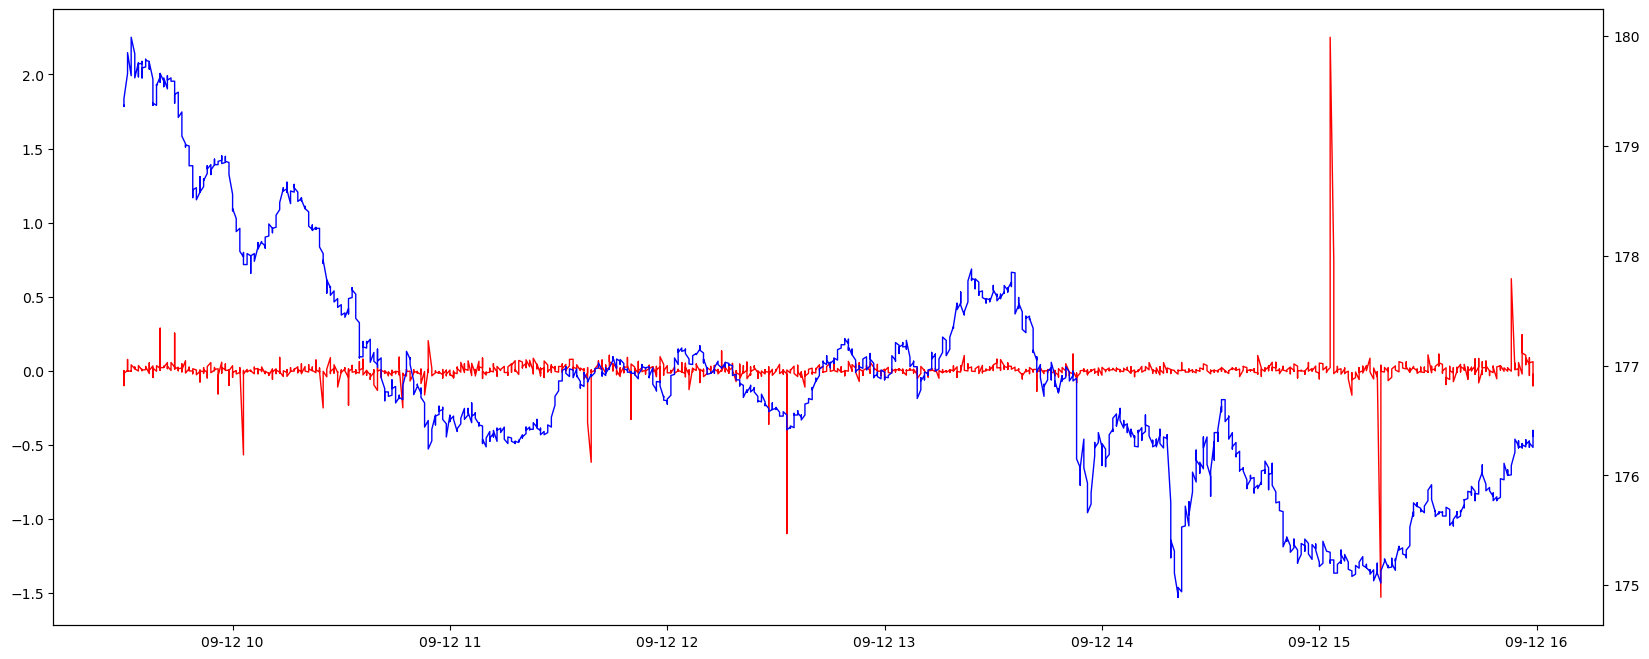

In [59]:
df = read_df[(read_df['Date'] >= start_date) & (read_df['Date'] <= end_date)].copy() # for sampling data

# Convert the 'Date_Time' column to a datetime object and set it as the index
df['Date_Time_recon'] = pd.to_datetime(df['Date-Time_ntz'], format='%Y-%m-%d %H:%M:%S.%f').dt.strftime("%Y-%m-%d %H:%M:%S")

# Set the 'Date_Time_recon' column as the index
df.set_index('Date_Time_recon', inplace=True)
df.index = pd.DatetimeIndex(df.index)

# Rename the 'Unnamed: 0' column to 'Seq'
df.rename(columns={'Unnamed: 0': 'Seq'}, inplace=True)

# Create transaction counter
df['trx_count'] = 1

# Clean data
cdf = clean_data(df)
clean_df = cdf[cdf["Type"] == "Trade"].copy()

# Sum Volume for interval 1 min
interval_df = clean_df.resample(interval_).agg({'Volume':'sum', 'Bid Size': 'sum', 'Ask Size': 'sum', 'Seq':'max'})
list_seq = list(interval_df['Seq'].unique())
interval_df.columns = [f'{c}_sum' for c in interval_df.columns[:-1]]+['Seq']

# Get the last transactions happened in every one minute interval
min1_df = clean_df[clean_df['Seq'].isin(list_seq)].copy()
min1_df.index = pd.DatetimeIndex(min1_df.index.strftime('%Y-%m-%d %H:%M:00'))
min1_df = pd.merge(min1_df.reset_index(), interval_df, on='Seq')

# Create trade data
trade_df = create_trade_df(min1_df.set_index('Date_Time_recon'))

fig, ax1 = plt.subplots(1, 1, figsize=(20,8), sharex=True)
ax2 = ax1.twinx()

ax1.plot(trade_df.index, trade_df['oib'], linestyle='-', color='r', linewidth=1)
ax2.plot(trade_df.index, trade_df['Price'], linestyle='-', color='b', linewidth=1)

In [29]:
trade_df.head()

,Seq,#RIC,Domain,Date-Time,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date-Time_ntz,Date,Time,trx_count,Volume_sum,Bid Size_sum,Ask Size_sum,mid_quote,tick_direction,quoted_spread,effective_spread,return,oib,spi,order_flow,price_change
Date_Time_recon,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-09-12 09:30:00,5057753,AAPL.OQ,Market Price,2023-09-12 09:30:14.935715317-04:00,Trade,179.37,1.0,179.36,61.0,179.39,2.0,NaN,2023-09-12 09:30:14.935715317,2023-09-12,09:30:14.935715,1,48466.0,5567.0,4677.0,179.375,-1.0,0.000167,0.000056,0.000000,-0.018363,0.000000,-59.0,0.00
2023-09-12 09:30:00,5059466,AAPL.OQ,Market Price,2023-09-12 09:30:29.165904369-04:00,Trade,179.36,300.0,179.31,6.0,179.36,4.0,^,2023-09-12 09:30:29.165904369,2023-09-12,09:30:29.165904,1,29129.0,5456.0,2533.0,179.335,1.0,0.000279,0.000279,-0.005575,-0.100347,-0.000033,-2.0,-0.01
2023-09-12 09:30:00,5060704,AAPL.OQ,Market Price,2023-09-12 09:30:44.796261487-04:00,Trade,179.42,62.0,179.41,9.0,179.44,4.0,NaN,2023-09-12 09:30:44.796261487,2023-09-12,09:30:44.796261,1,20947.0,587.0,597.0,179.425,-1.0,0.000167,0.000056,0.033452,0.000477,0.000968,-5.0,0.06
2023-09-12 09:30:00,5061446,AAPL.OQ,Market Price,2023-09-12 09:30:59.521470687-04:00,Trade,179.43,3.0,179.42,1.0,179.45,3.0,NaN,2023-09-12 09:30:59.521470687,2023-09-12,09:30:59.521470,1,8364.0,401.0,250.0,179.435,-1.0,0.000167,0.000056,0.005574,-0.018054,0.003333,2.0,0.01
2023-09-12 09:31:00,5062800,AAPL.OQ,Market Price,2023-09-12 09:31:14.986457428-04:00,Trade,179.66,100.0,179.65,4.0,179.67,1.0,^,2023-09-12 09:31:14.986457428,2023-09-12,09:31:14.986457,1,18623.0,626.0,669.0,179.660,1.0,0.000111,0.000000,0.128184,0.002309,0.002300,-3.0,0.23


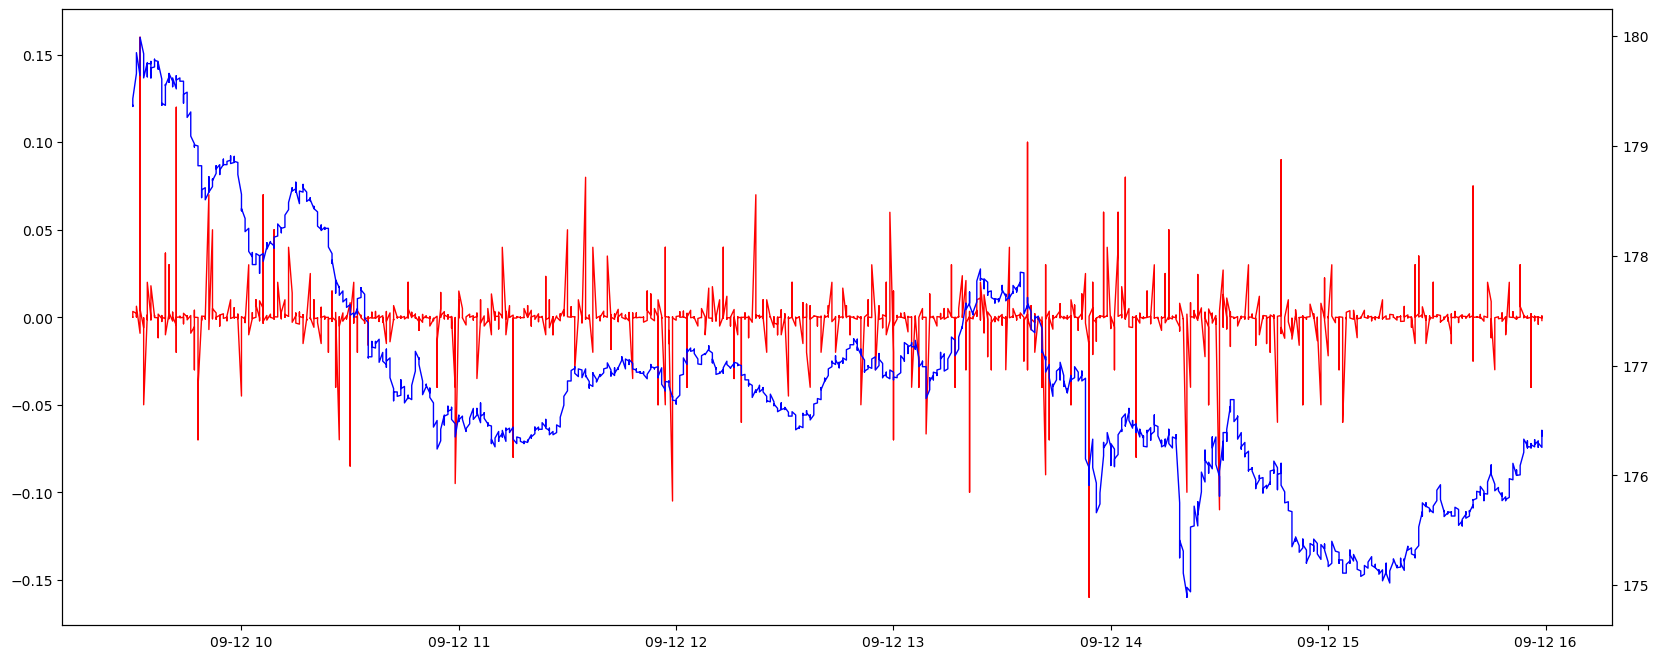

In [42]:
fig, ax1 = plt.subplots(1, 1, figsize=(20,8), sharex=True)
ax2 = ax1.twinx()

ax1.plot(trade_df.index, trade_df['spi'], linestyle='-', color='r', linewidth=1)
ax2.plot(trade_df.index, trade_df['Price'], linestyle='-', color='b', linewidth=1)

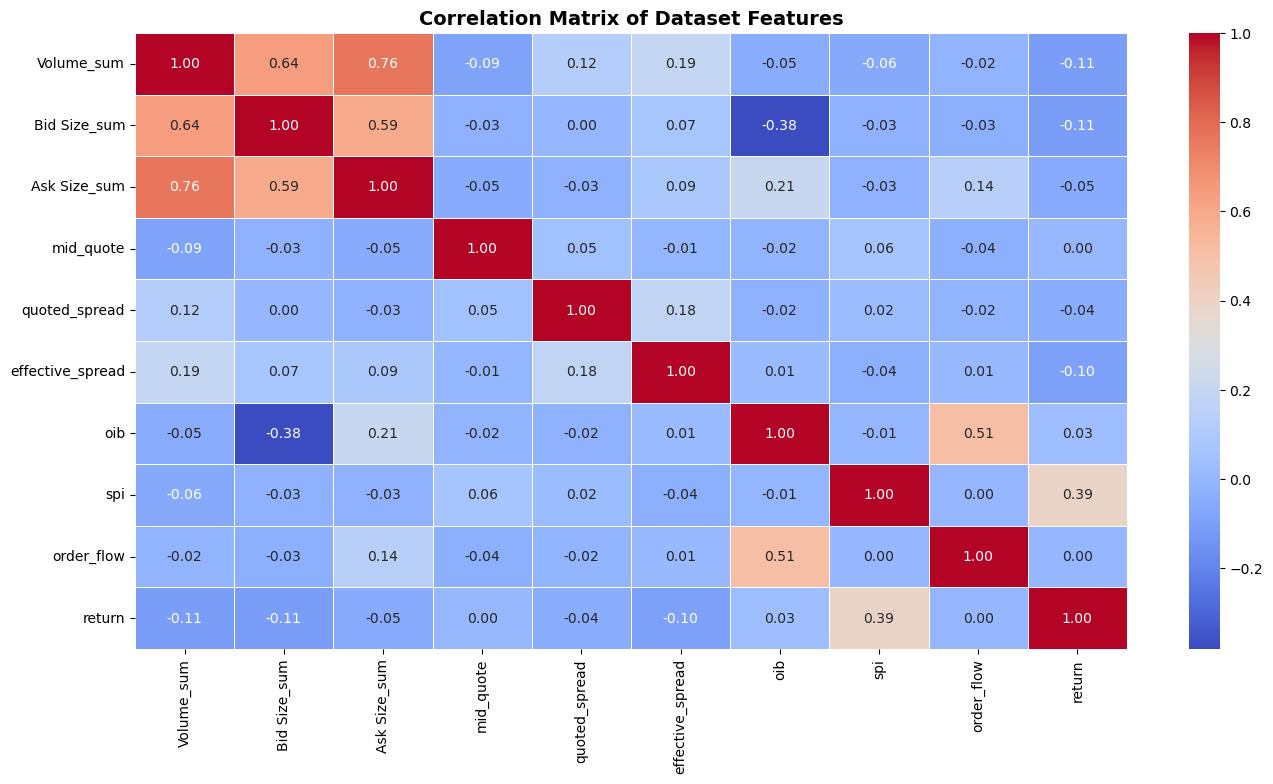

In [52]:
features = ['Volume_sum', 'Bid Size_sum', 'Ask Size_sum', 'mid_quote', 'quoted_spread', 'effective_spread', 'oib', 'spi', 'order_flow', 'return']

corr = trade_df[features].corr()

plt.figure(figsize=(16, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Dataset Features', fontsize=14, fontweight="bold")
plt.show()

In [53]:
# scaler = StandardScaler()
# trade_df[['delta_p', 'oib']] = scaler.fit_transform(trade_df[['oib', 'return']])

# print(trade_df.head())

delta_p = trade_df['return'] # Change in price or return
spi = trade_df['spi']    # Order Imbalance

# Adding a constant to the OIB data for the intercept (alpha)
spi_with_constant = sm.add_constant(spi)

# Creating the model
model = sm.OLS(delta_p, spi_with_constant)

# Fitting the model
results = model.fit()

# Printing the parameters (alpha and beta)
print("Alpha (intercept) and Beta (coefficient) estimates:")
print(results.params)

# Printing the residuals (epsilon) for each observation
print("\nEpsilon (residuals) for each observation:")
print(results.resid)


Alpha (intercept) and Beta (coefficient) estimates:
const   -0.000522
spi      0.915449
dtype: float64

Epsilon (residuals) for each observation:
Date_Time_recon
2023-09-12 09:30:00    0.000522
2023-09-12 09:30:00   -0.005022
2023-09-12 09:30:00    0.033089
2023-09-12 09:30:00    0.003044
2023-09-12 09:31:00    0.126601
                         ...   
2023-09-12 15:58:00    0.006103
2023-09-12 15:59:00   -0.021801
2023-09-12 15:59:00    0.042388
2023-09-12 15:59:00    0.045548
2023-09-12 15:59:00   -0.026125
Length: 1560, dtype: float64


In [54]:
print(results.rsquared)
print(np.sqrt(results.mse_resid))
print(results.fvalue)

0.1492105399681527
0.0341183629021711
273.24036344042145


In [49]:
# scaler = StandardScaler()
trade_df['spi_lagged'] = trade_df['spi'].shift(5)

trade_df = trade_df.dropna()

delta_p = trade_df['return'] # Change in price or return
spi = trade_df['spi_lagged']    # Order Imbalance

# Adding a constant to the OIB data for the intercept (alpha)
spi_with_constant = sm.add_constant(spi)

# Creating the model
model = sm.OLS(delta_p, spi_with_constant)

# Fitting the model
results = model.fit()

# Printing the parameters (alpha and beta)
print("Alpha (intercept) and Beta (coefficient) estimates:")
print(results.params)

# Printing the residuals (epsilon) for each observation
print("\nEpsilon (residuals) for each observation:")
print(results.resid)


Alpha (intercept) and Beta (coefficient) estimates:
const        -0.001611
spi_lagged    0.426011
dtype: float64

Epsilon (residuals) for each observation:
Date_Time_recon
2023-09-12 09:34:00    0.046162
2023-09-12 09:35:00    0.011758
2023-09-12 09:35:00   -0.082136
2023-09-12 09:36:00    0.028836
2023-09-12 09:37:00    0.024425
                         ...   
2023-09-12 15:58:00    0.018632
2023-09-12 15:58:00    0.007369
2023-09-12 15:59:00   -0.021355
2023-09-12 15:59:00    0.044174
2023-09-12 15:59:00    0.046832
Length: 559, dtype: float64


In [50]:
print(results.rsquared)
print(np.sqrt(results.mse_resid))
print(results.fvalue)

4.508205288988876e-05
0.03954656953429213
0.025111835552762755


In [58]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Assuming 'df' is your DataFrame and it's indexed by time in ascending order
trade_df['BidSizeChange'] = trade_df['Bid Size_sum'].diff()
trade_df['AskSizeChange'] = trade_df['Ask Size_sum'].diff()
trade_df['PriceChange'] = trade_df['Price'].diff()

# Indicators for price moving up or down
trade_df['PriceUp'] = np.where(trade_df['PriceChange'] > 0, 1, 0)
trade_df['PriceDown'] = np.where(trade_df['PriceChange'] < 0, 1, 0)

# Calculate Order Flow Imbalance
trade_df['OFI'] = (trade_df['BidSizeChange'] * trade_df['PriceUp']) - (trade_df['AskSizeChange'] * trade_df['PriceDown'])

# Drop the first row as it will have NaN due to diff()
trade_df = trade_df.dropna()

# Correlation matrix including OFI and Price
correlation_matrix = trade_df[['OFI', 'Price']].corr()
print("Correlation Matrix:\n", correlation_matrix)

# Regression Analysis: OFI on PriceChange
# Adding a constant for intercept term
X = sm.add_constant(trade_df['OFI'])  # Independent variable
y = trade_df['PriceChange']           # Dependent variable

model = sm.OLS(y, X).fit()
print(model.summary())

# Note: Interpret R-squared and coefficients to understand OFI's effect on price changes.


Correlation Matrix:
             OFI     Price
OFI    1.000000  0.012473
Price  0.012473  1.000000
                            OLS Regression Results                            
Dep. Variable:            PriceChange   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.110
Date:                Thu, 11 Apr 2024   Prob (F-statistic):              0.293
Time:                        17:47:45   Log-Likelihood:                 469.86
No. Observations:                 562   AIC:                            -935.7
Df Residuals:                     560   BIC:                            -927.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [61]:
# Correlation matrix including Bid-Ask Spread and PriceChange
correlation_matrix = trade_df[['quoted_spread', 'price_change']].corr()
print("Correlation Matrix:\n", correlation_matrix)

# Regression Analysis: Bid-Ask Spread on PriceChange
# Adding a constant for intercept term
X = sm.add_constant(trade_df['quoted_spread'])  # Independent variable
y = trade_df['price_change']                    # Dependent variable

model = sm.OLS(y, X).fit()
print(model.summary())

# Note: Interpret R-squared and coefficients to understand the effect of Bid-Ask Spread on price changes.


Correlation Matrix:
                quoted_spread  price_change
quoted_spread       1.000000     -0.044892
price_change       -0.044892      1.000000
                            OLS Regression Results                            
Dep. Variable:           price_change   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.146
Date:                Thu, 11 Apr 2024   Prob (F-statistic):             0.0763
Time:                        17:49:41   Log-Likelihood:                 2043.8
No. Observations:                1560   AIC:                            -4084.
Df Residuals:                    1558   BIC:                            -4073.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|   